In [2]:
import os
from pathlib import Path

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy import signal

from skimage import color, data, restoration

from vlab.images.transform import _idx_from_coord
from vlab.data.io import get_slice, get_metadata
from vlab.images.transform import mip_threeview, apply_lut
from vlab.data.annotations import load_annotations

In [3]:
control2_path = Path(r'X:\Mahdi\Archived\Alison Kochersberger\PHX2910\01_22_2021\animal_2\run_1\compressed')
mutant3_path = Path(r'X:\Mahdi\Archived\Alison Kochersberger\XE2551\01_22_2021\animal_3\run_1\compressed')
mutant4_path = Path(r'X:\Mahdi\Archived\Alison Kochersberger\XE2551\01_22_2021\animal_4\run_1\compressed')

In [4]:
def plot_2d(x, grid):
    plt.figure(figsize=(10, 10))
    plt.grid(grid)
    plt.imshow(x)
    plt.show()
    
def plot_3d(v, grid=True):
    r = v[0]
    g = v[1]
    if v.shape[0] == 3:
        b = v[2]
    else:
        b = np.zeros_like(r)
    plot_2d(np.stack([r, g, b], axis=-1), grid)
    
def plot_3d_cv2(v, grid=False):
    plot_2d(np.stack([v[:,:,2], v[:,:,1], v[:,:,0]], axis=-1), grid)

def plot_4d(v, grid=True):
    r = mip_threeview(v[0])
    g = mip_threeview(v[1])
    b = np.zeros_like(r)
    plot_2d(np.stack([r, g, b], axis=-1), grid)
    
def get_rotated(v, angle=0):
    return rotate(v[...], angle, axes=(2,3), reshape=True)
    
            
def get_aligned(v):
    output = np.zeros_like(v)
    output[1,...] = v[1, ...]
    mip_v = np.max(v, axis=1)
    
    w = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)
    
    input_mask = np.uint8(mip_v[1] > -1)
    (_, w) = cv2.findTransformECC(mip_v[1], mip_v[0], w, cv2.MOTION_EUCLIDEAN,
                                  criteria, input_mask, 5)
    for z in range(v.shape[1]):
        output[0, z, :, :] = cv2.warpAffine(v[0, z, :, :], w, (v.shape[3], v.shape[2]),
                                            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return output



def gkern(kernlen=3, std=1):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d / np.sum(gkern2d)

def sharpen(frame, ct):
    kernel = np.array([[-1, -1, -1],
                       [-1, ct, -1],
                       [-1, -1, -1]])
    return signal.convolve2d(frame, kernel, 'same')
    
    
def blur(frame, kernel_size=3, kernel_sigma=1):
    kernel = gkern(kernlen=kernel_size, std=kernel_sigma)
    return signal.convolve2d(frame, kernel, 'same')

def denoise(frame, kernel_size=3, kernel_sigma=1 ,iterations=30):
    # tested. adds more noise
    kernel = gkern(kernlen=kernel_size, std=kernel_sigma)
    temp = signal.convolve2d(frame, kernel, 'same')
    return restoration.richardson_lucy(temp, kernel, iterations)

In [5]:
path = mutant4_path

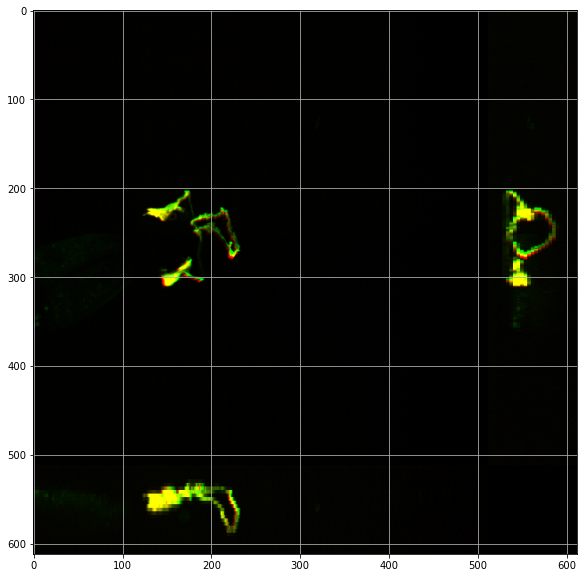

In [6]:
raw_vol = get_slice(path, 0)
plot_4d(raw_vol)

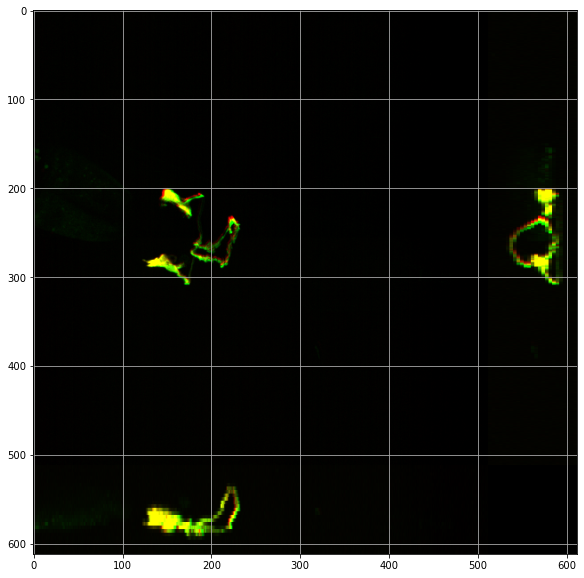

In [7]:
flip_x = True
flip_y = False

if flip_x:
    raw_vol = np.flip(raw_vol, (1, 2))
if flip_y:
    raw_vol = np.flip(raw_vol, (1, 3))

plot_4d(raw_vol)

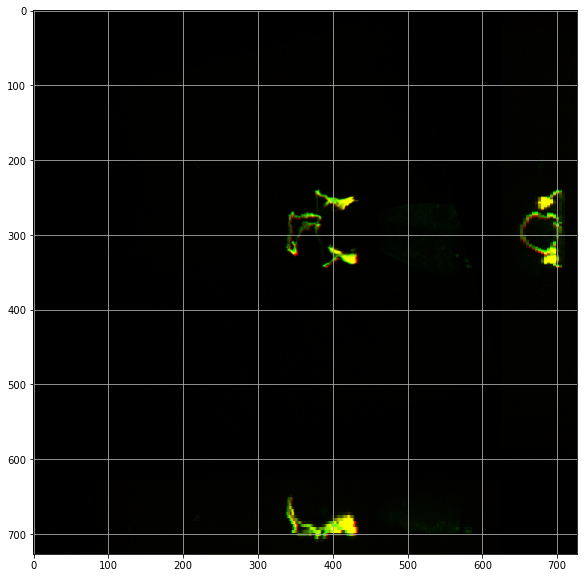

In [9]:
rotated_vol = get_rotated(raw_vol, angle=-165)
rotated_vol = np.clip(rotated_vol, raw_vol.min(), raw_vol.max())

plot_4d(rotated_vol)

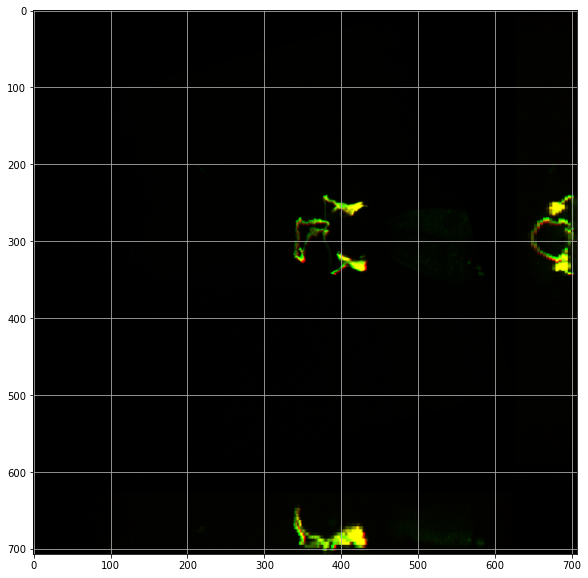

In [10]:
z_cropped_vol = rotated_vol[:, 1:-4, ...]

plot_4d(z_cropped_vol)

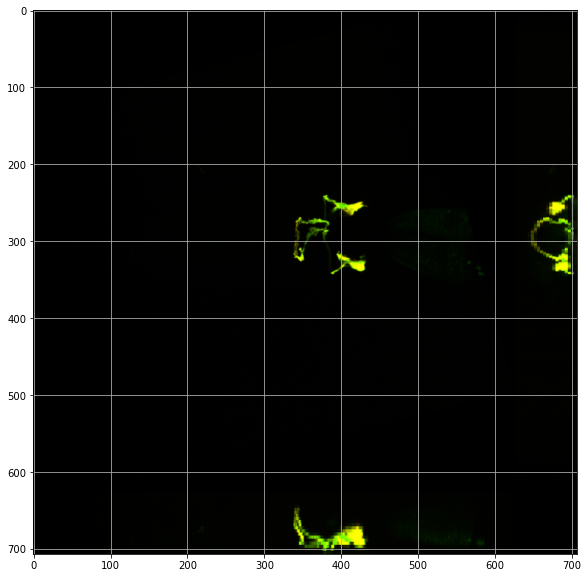

In [11]:
aligned_vol = get_aligned(z_cropped_vol)
aligned_vol = np.clip(aligned_vol, raw_vol.min(), raw_vol.max())

plot_4d(aligned_vol)

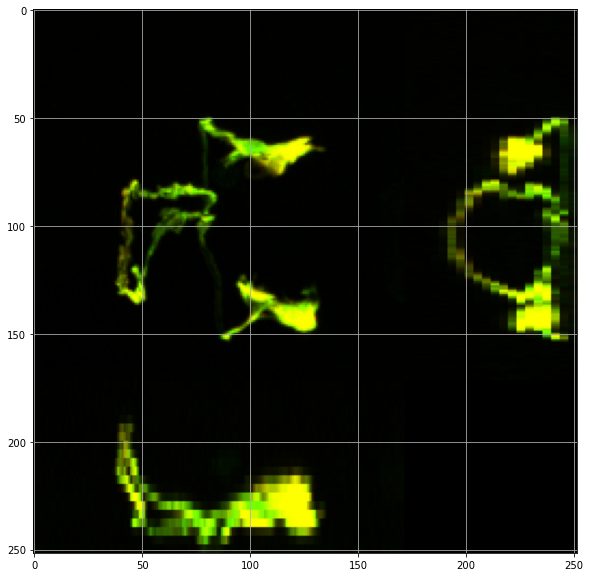

In [19]:
cropped_vol = aligned_vol[:,:,190:362,300:472]
plot_4d(cropped_vol, grid=True)

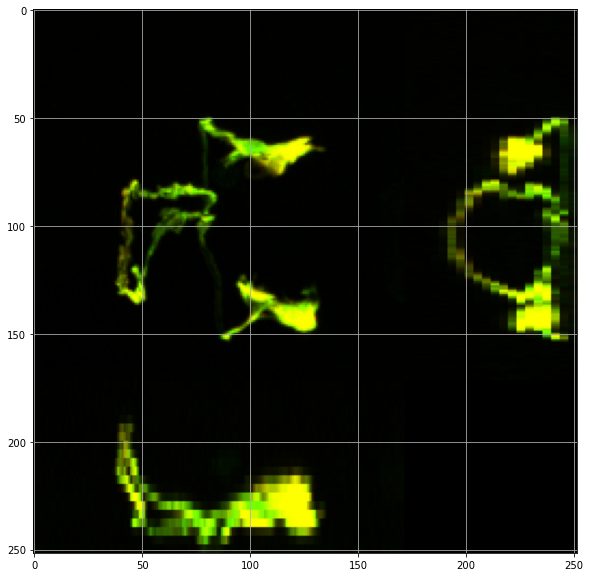

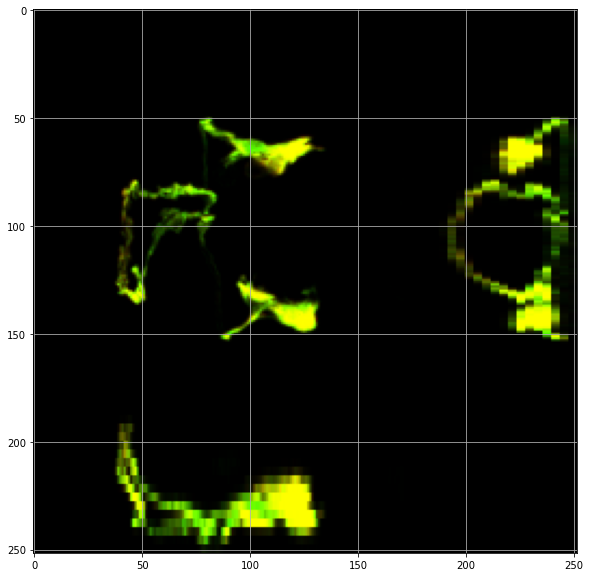

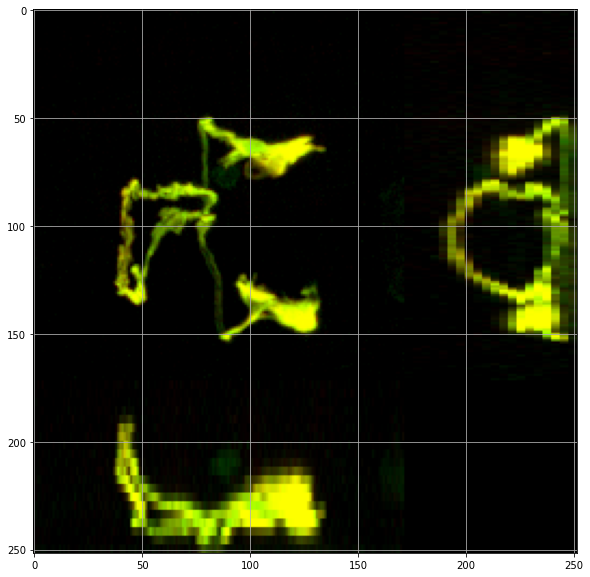

In [20]:
threshold_vol = np.zeros_like(cropped_vol)

for c in range(cropped_vol.shape[0]):
    gamma_corrected = cropped_vol[c] ** 0.5
    temp = np.clip((gamma_corrected - np.quantile(gamma_corrected, 0.97)) / (gamma_corrected.max() - np.quantile(gamma_corrected, 0.97)) , 0.0, 1.0)
    threshold_vol[c] = temp ** 2.0

plot_4d(cropped_vol)    
plot_4d(threshold_vol)
temp = np.stack([threshold_vol[0] ** 0.45, threshold_vol[1] ** 0.45])
plot_4d(temp)

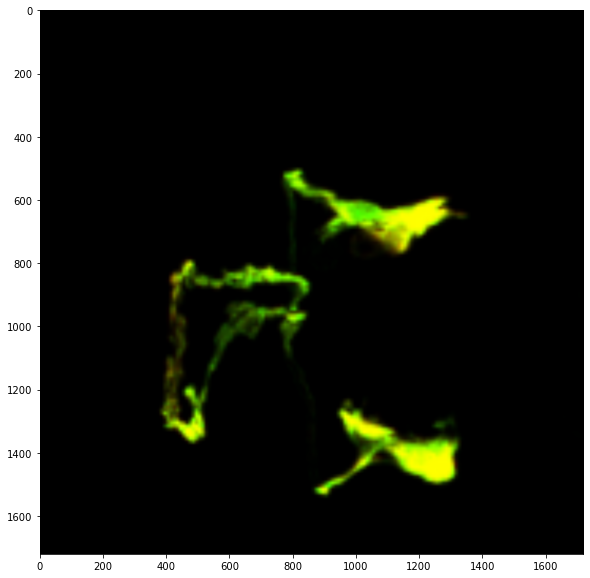

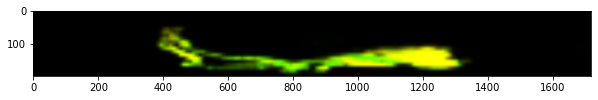

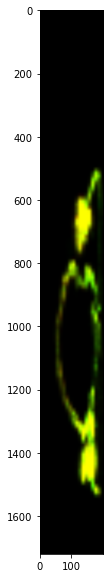

In [21]:
scale = (10, 10, 10)

mip_z = np.dstack((np.zeros_like(np.max(threshold_vol[0], axis=(0))),
                   np.max(threshold_vol[1], axis=(0)),
                   np.max(threshold_vol[0], axis=(0))))
mip_y = np.dstack((np.zeros_like(np.max(threshold_vol[0], axis=(1))),
                   np.max(threshold_vol[1], axis=(1)),
                   np.max(threshold_vol[0], axis=(1))))
mip_x = np.transpose(np.dstack((np.zeros_like(np.max(threshold_vol[0], axis=(2))),
                                np.max(threshold_vol[1], axis=(2)),
                                np.max(threshold_vol[0], axis=(2)))), (1, 0, 2))

resized_z = cv2.resize(mip_z, (scale[2] * mip_z.shape[1], scale[1] * mip_z.shape[0]))
resized_y = cv2.resize(mip_y, (scale[2] * mip_y.shape[1], scale[0] * mip_y.shape[0]))
resized_x = cv2.resize(mip_x, (scale[0] * mip_x.shape[1], scale[1] * mip_x.shape[0]))

scaled_y = cv2.resize(mip_y, (mip_y.shape[1], 1 * mip_y.shape[0]))
scaled_x = cv2.resize(mip_x, (1 * mip_x.shape[1], mip_x.shape[0]))


plot_3d_cv2(resized_z)
plot_3d_cv2(resized_y)
plot_3d_cv2(resized_x)

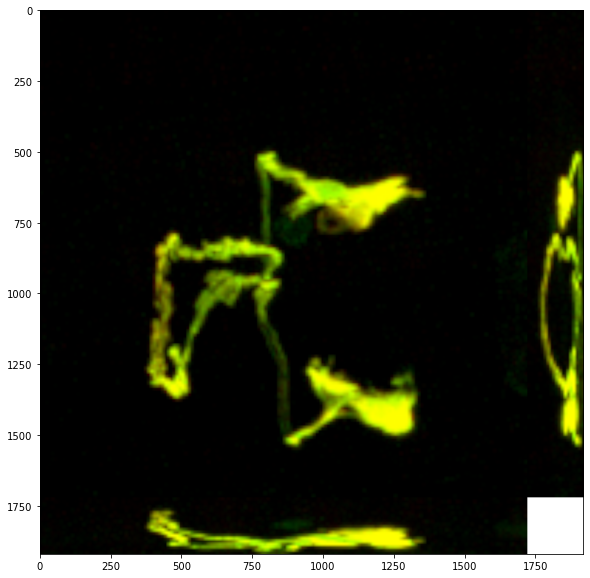

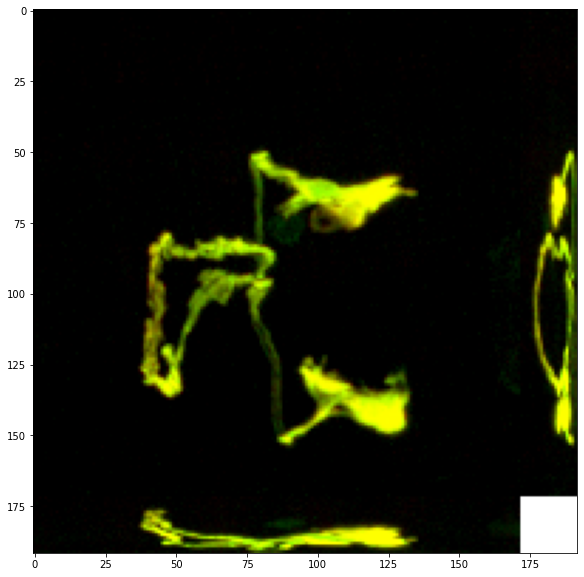

In [22]:
resized_mip = np.ones((resized_z.shape[0] + resized_y.shape[0], resized_z.shape[1] + resized_x.shape[1], 3))
resized_mip[:resized_z.shape[0], :resized_z.shape[1]] = resized_z ** 0.45
resized_mip[resized_z.shape[0]:, :resized_z.shape[1]] = resized_y ** 0.45
resized_mip[:resized_z.shape[0], resized_z.shape[1]:] = resized_x ** 0.45
plot_3d_cv2(resized_mip)

mip = np.ones((mip_z.shape[0] + scaled_y.shape[0], mip_z.shape[1] + scaled_y.shape[0], 3))
mip[:mip_z.shape[0], :mip_z.shape[1]] = mip_z ** 0.45
mip[mip_z.shape[0]:, :mip_z.shape[1]] = scaled_y ** 0.45
mip[:mip_z.shape[0], mip_z.shape[1]:] = scaled_x ** 0.45
plot_3d_cv2(mip)

In [23]:
resized_uint8 = apply_lut(resized_mip, 0.0, 1.0, np.uint8)
uint8 = apply_lut(mip, 0.0, 1.0, np.uint8)

file_name1 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4 resized.png")
file_name2 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4.png")

array_name1 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4 resized.npy")
array_name2 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4.npy")

cv2.imwrite(file_name1, resized_uint8)
cv2.imwrite(file_name2, uint8)

np.save(array_name1, resized_uint8)
np.save(array_name2, uint8)

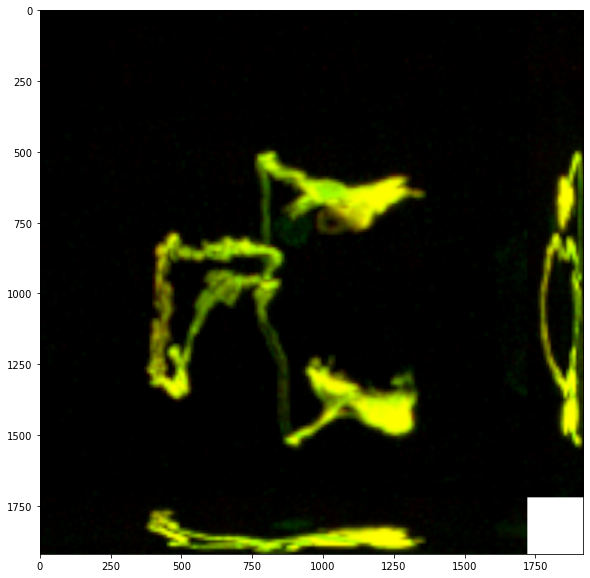

In [24]:
plot_3d_cv2(resized_uint8)

200 1720 1720


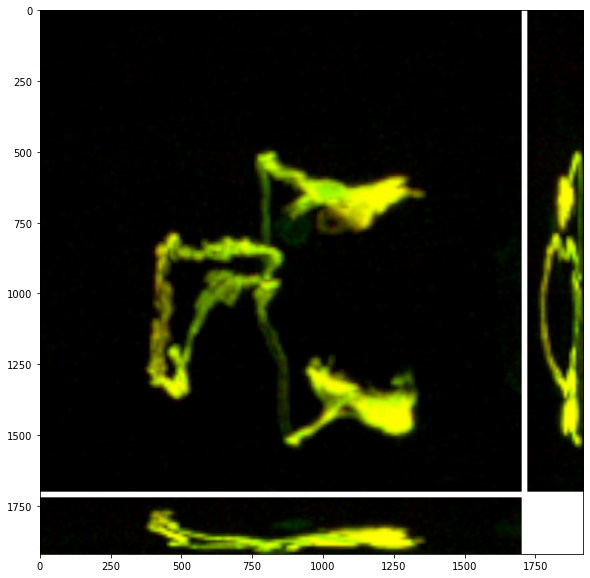

In [25]:
y, x, _ = resized_z.shape
z, x, _ = resized_y.shape
print(z, y, x)
sectioned_image = resized_uint8.copy()

sectioned_image[y-20:y, :, :] = 255
sectioned_image[:, x-20:x, :] = 255

plot_3d_cv2(sectioned_image)

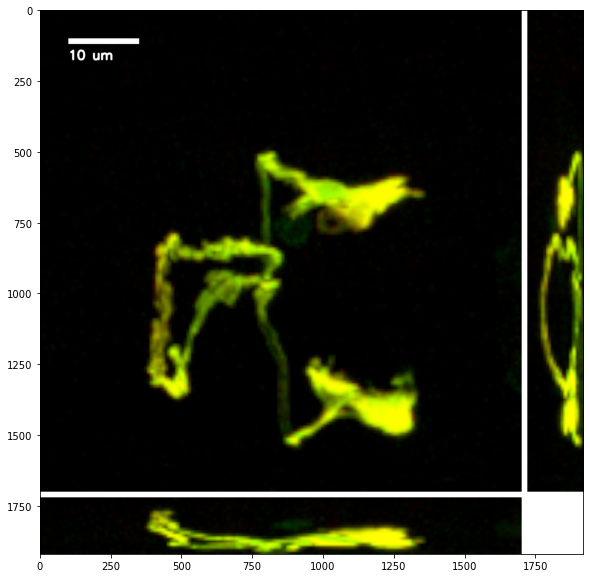

In [26]:
scalebar_image = sectioned_image.copy()


offset_x = 100
offset_y = 100
bar_h = 20
bar_w = 250
font_scale=1.5
thickness=5
scalebar_image[offset_y:offset_y + bar_h, offset_x:offset_x + bar_w, :] = 255
txt1 = '10 um'
(w1, h1), bl1 = cv2.getTextSize(text=txt1, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
scalebar_image = cv2.putText(scalebar_image, txt1, (offset_x, offset_y + bar_h + h1 + 20), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

plot_3d_cv2(scalebar_image)

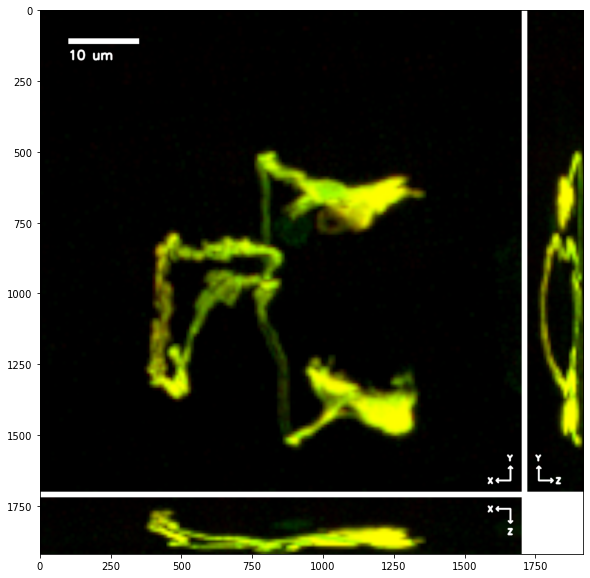

In [27]:
coordinate_image = scalebar_image.copy()
bar_h = 5
coordinate_image = cv2.arrowedLine(coordinate_image, (x-60, y-60), (x-110, y-60), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'X', (x-140, y-50), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

coordinate_image = cv2.arrowedLine(coordinate_image, (x-60, y-60), (x-60, y-110), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'Y', (x-70, y-130), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

coordinate_image = cv2.arrowedLine(coordinate_image, (x-60, y+40), (x-110, y+40), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'X', (x-140, y+50), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale  * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

coordinate_image = cv2.arrowedLine(coordinate_image, (x-60, y+40), (x-60, y+90), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'Z', (x-70, y+130), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale  * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

coordinate_image = cv2.arrowedLine(coordinate_image, (x+40, y-60), (x+90, y-60), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'Z', (x+100, y-50), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale  * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

coordinate_image = cv2.arrowedLine(coordinate_image, (x+40, y-60), (x+40, y-110), 
                (255, 255, 255), bar_h, tipLength = 0.2)
coordinate_image = cv2.putText(coordinate_image, 'Y', (x+30, y-130), cv2.FONT_HERSHEY_SIMPLEX, 
                             font_scale  * 0.6, (255, 255, 255), thickness, cv2.LINE_AA)

plot_3d_cv2(coordinate_image)

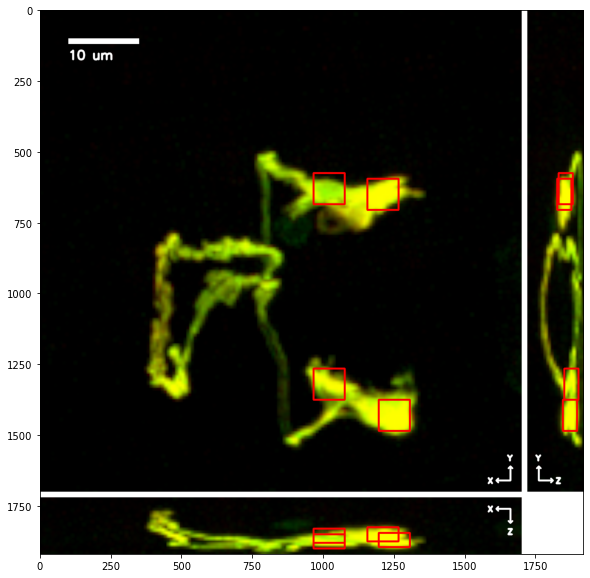

In [45]:
# location of each neuron, calculated using manual annotations
# zyxs = [[75,280,950], [75,990,930]]
# zyxs = [[158,550,650], [135,510,1120], [120,1000,1170], [155,1090,1030]]
# zyxs = [[135,630,1020], [130,650,1210], [150,1430,1250], [155,1320,1020]]
annotated_image = coordinate_image.copy()

for i ,zyx in enumerate(zyxs):
        annotated_image = cv2.rectangle(annotated_image, (zyx[2]-55,zyx[1]-55), (zyx[2]+55,zyx[1]+55), (0,0,255), 5)
        annotated_image = cv2.rectangle(annotated_image, (zyx[2]-55,y+zyx[0]-25), (zyx[2]+55,y+zyx[0]+25), (0,0,255), 5)
        annotated_image = cv2.rectangle(annotated_image, (x+zyx[0]-25,zyx[1]-55), (x+zyx[0]+25,zyx[1]+55), (0,0,255), 5)
plot_3d_cv2(annotated_image)

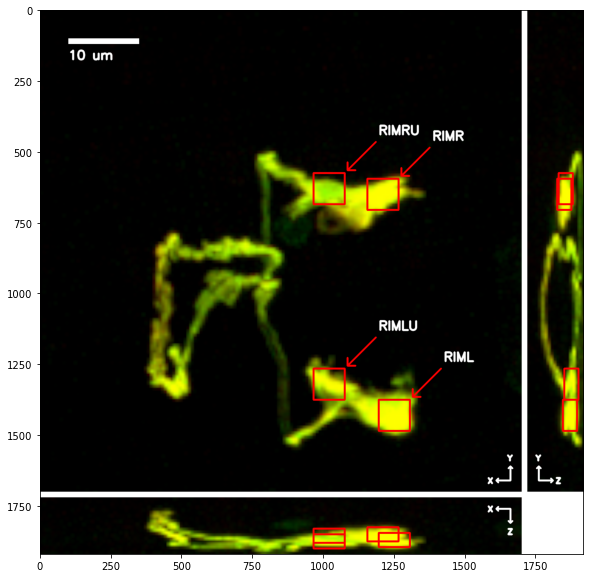

In [46]:
# name of each neuron, manually identified
# names = ['RIMR', 'RIML']
# names = ['RIMRU', 'RIMR', 'RIML', 'RIMLU']
# names = ['RIMRU', 'RIMR', 'RIML', 'RIMLU']
labeled_image = annotated_image.copy()

for i, zyx in enumerate(zyxs):
    corner = [zyx[1] - 55, zyx[2] + 55]
    labeled_image = cv2.arrowedLine(labeled_image, (corner[1] + 110, corner[0] - 110), (corner[1] + 10, corner[0] - 10), 
                                    (0, 0, 255), bar_h, tipLength = 0.2)
    txt = names[i]
    (w, h), bl = cv2.getTextSize(text=txt, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
    labeled_image = cv2.putText(labeled_image, txt, (corner[1] + 120, corner[0] - 120 - bl), cv2.FONT_HERSHEY_SIMPLEX, 
                                font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# name = names[0]
# zyx = zyxs[0]
# corner = [zyx[1] - 55, zyx[2] - 55]
# labeled_image = cv2.arrowedLine(labeled_image, (corner[1] - 110, corner[0] - 110), (corner[1] - 10, corner[0] - 10), 
#                                 (0, 0, 255), bar_h, tipLength = 0.2)
# (w, h), bl = cv2.getTextSize(text=name, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
# labeled_image = cv2.putText(labeled_image, name, (corner[1] - 120 - w, corner[0] - 120 - bl), cv2.FONT_HERSHEY_SIMPLEX, 
#                             font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# name = names[1]
# zyx = zyxs[1]
# corner = [zyx[1] - 55, zyx[2] + 55]
# labeled_image = cv2.arrowedLine(labeled_image, (corner[1] + 110, corner[0] - 110), (corner[1] + 10, corner[0] - 10), 
#                                 (0, 0, 255), bar_h, tipLength = 0.2)
# (w, h), bl = cv2.getTextSize(text=name, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
# labeled_image = cv2.putText(labeled_image, name, (corner[1] + 120, corner[0] - 120 - bl), cv2.FONT_HERSHEY_SIMPLEX, 
#                             font_scale, (255, 255, 255), thickness, cv2.LINE_AA)


# name = names[2]
# zyx = zyxs[2]
# corner = [zyx[1] - 55, zyx[2] + 55]
# labeled_image = cv2.arrowedLine(labeled_image, (corner[1] + 110, corner[0] - 110), (corner[1] + 10, corner[0] - 10), 
#                                 (0, 0, 255), bar_h, tipLength = 0.2)
# (w, h), bl = cv2.getTextSize(text=name, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
# labeled_image = cv2.putText(labeled_image, name, (corner[1] + 120, corner[0] - 120 - bl), cv2.FONT_HERSHEY_SIMPLEX, 
#                             font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

# name = names[3]
# zyx = zyxs[3]
# corner = [zyx[1] + 55, zyx[2] + 55]
# labeled_image = cv2.arrowedLine(labeled_image, (corner[1] + 110, corner[0] + 110), (corner[1] + 10, corner[0] + 10), 
#                                 (0, 0, 255), bar_h, tipLength = 0.2)
# (w, h), bl = cv2.getTextSize(text=name, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=font_scale, thickness=thickness)
# labeled_image = cv2.putText(labeled_image, name, (corner[1] + 120, corner[0] + 120 + h + bl), cv2.FONT_HERSHEY_SIMPLEX, 
#                             font_scale, (255, 255, 255), thickness, cv2.LINE_AA)

plot_3d_cv2(labeled_image)


In [47]:
file_name = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4 resized annotated.png")

array_name = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551', "EX2551 animal_4 resized annotated.npy")

cv2.imwrite(file_name, labeled_image)

np.save(array_name, labeled_image)

In [24]:
file_name1 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551\micrographs', "EX2551 animal_4 resized annotated.npy")
file_name2 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551\micrographs', "EX2551 animal_3 resized annotated.npy")
file_name3 = os.path.join(r'C:\Users\Mahdi\OneDrive - Northeastern University\Alison Kochersberger\XE2551\micrographs', "PHX2910 animal_2 resized annotated.npy")

images = [np.load(file_name1), np.load(file_name2), np.load(file_name3)]